# Data Analysis Notebook For Hartree-Fock Stability
---

This notebook and the corresponding python file at pyfiles.HFSAnalyzer contain all data analysis and plotting scripts used in the Hatree-Fock Stability of the Homogeneous Electron Gas (HEG). The Data all comes from the executables in the src directory of the project. The logfiles are all in .json format, allowing for easy parsing, while also being human readable (except some large arrays). 

In [1]:
import pyfiles.HFSAnalyzer as HFSA

import os
import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

workdir = '/home/evan/git/HF-Stability/analysis/'

datadir = workdir + 'log'

In [2]:
%matplotlib inline

alpha = 0.9   # Change from RGB colors to RGBA with this alpha value
mycolors = np.asarray(sns.color_palette())
zeros = alpha * np.ones(len(mycolors))
mycolors = np.hstack([mycolors, zeros[:, None]])

sns.set_style("white")
sns.set_context("talk")
sns.set_palette('muted')

# Plotting style
rc['lines.linewidth'] = 3.0
rc['lines.markersize'] = 8.0
rc['lines.solid_capstyle'] = 'round'
rc['axes.labelsize'] = 18.0
rc['axes.titlesize'] = 20.0
rc['xtick.labelsize'] = 16.0
rc['ytick.labelsize'] = 16.0
rc['legend.fontsize'] = 15.0
rc['font.size'] = 18.0

sns.set_style({'xtick.direction': u'in',
 'xtick.major.size': 12.0,
 'xtick.minor.size': 6.0,
 'ytick.direction': u'in',
 'ytick.major.size': 12.0,
 'ytick.minor.size': 6.0,
 'axes.linewidth': 2.0})

# Size, saving and stuff
#rc['text.usetex'] = True
rc['figure.figsize'] = (5, 5)
rc['savefig.format'] = 'eps'
rc['savefig.transparent'] = True
rc['savefig.bbox'] = 'tight'
rc['savefig.directory'] = os.chdir(workdir + '/../doc/images')

## Load the Data
---

The data is parsed and collected in a single dataframe. 

In [3]:
df =  HFSA.json_dir_to_df(datadir)

df.dropna(axis='rows', subset=['NDIM', 'rs', 'Nk', 'mycase', 'dav_min_eval'], inplace=True)
df['Nk'] = df['Nk'].astype(int)
df['NDIM'] = df['NDIM'].astype(int)
df['mycase'] = df['mycase'].astype(str)
# Before I implemented the delta function version, all versions
# used the coulomb potential. So casting NaN to False is appropriate in 
# this scenario.
df['use_delta_1D'] = df['use_delta_1D'].astype(bool)

## Sort Data
---

Sort the data into groups, storing each as a key, value pair in a dictionary. I think this copies but so far I've had no issues with RAM

In [4]:
# Split into groups
def dict_subview(dic, keys):
    return {key : val for (key, val) in dic.items() if key in keys}

data = {
     'all'   : df
    ,'3D'    : df[df['NDIM'] == 3]
    ,'2D'    : df[df['NDIM'] == 2]
    ,'3Drs12': df[np.isclose(df['rs'].as_matrix(), 1.2) & (df['NDIM'] == 3)]
    ,'2Drs12': df[np.isclose(df['rs'].as_matrix(), 1.2) & (df['NDIM'] == 2)]
    
    ,'3DR2R' : df[((df.mycase.str.contains('cRHF2cRHF')) & (df['NDIM'] == 3))]    
    ,'3DR2U' : df[((df.mycase.str.contains('cRHF2cUHF')) & (df['NDIM'] == 3))]
    ,'3DR2G' : df[((df.mycase.str.contains('cRHF2cGHF')) & (df['NDIM'] == 3))]
    ,'3DU2U' : df[((df.mycase.str.contains('cUHF2cUHF')) & (df['NDIM'] == 3))]

    ,'2DR2R' : df[((df.mycase.str.contains('cRHF2cRHF')) & (df['NDIM'] == 2))]    
    ,'2DR2U' : df[((df.mycase.str.contains('cRHF2cUHF')) & (df['NDIM'] == 2))]
    ,'2DR2G' : df[((df.mycase.str.contains('cRHF2cGHF')) & (df['NDIM'] == 2))]
    ,'2DU2U' : df[((df.mycase.str.contains('cUHF2cUHF')) & (df['NDIM'] == 2))]
    
    ,'1DR2R' : df[((df.mycase.str.contains('cRHF2cRHF')) & (df['NDIM'] == 1))]
    ,'1DR2U' : df[((df.mycase.str.contains('cRHF2cUHF')) & (df['NDIM'] == 1))]
}

# remove emptys
data = {key: val for (key, val) in data.items() if len(val) > 0}

### Runtimes 
--- 

Me getting an idea of runtimes and scalings for various procedures. This is not meant for presentation, but for spotting obvious outliers and strange scalings, etc. 

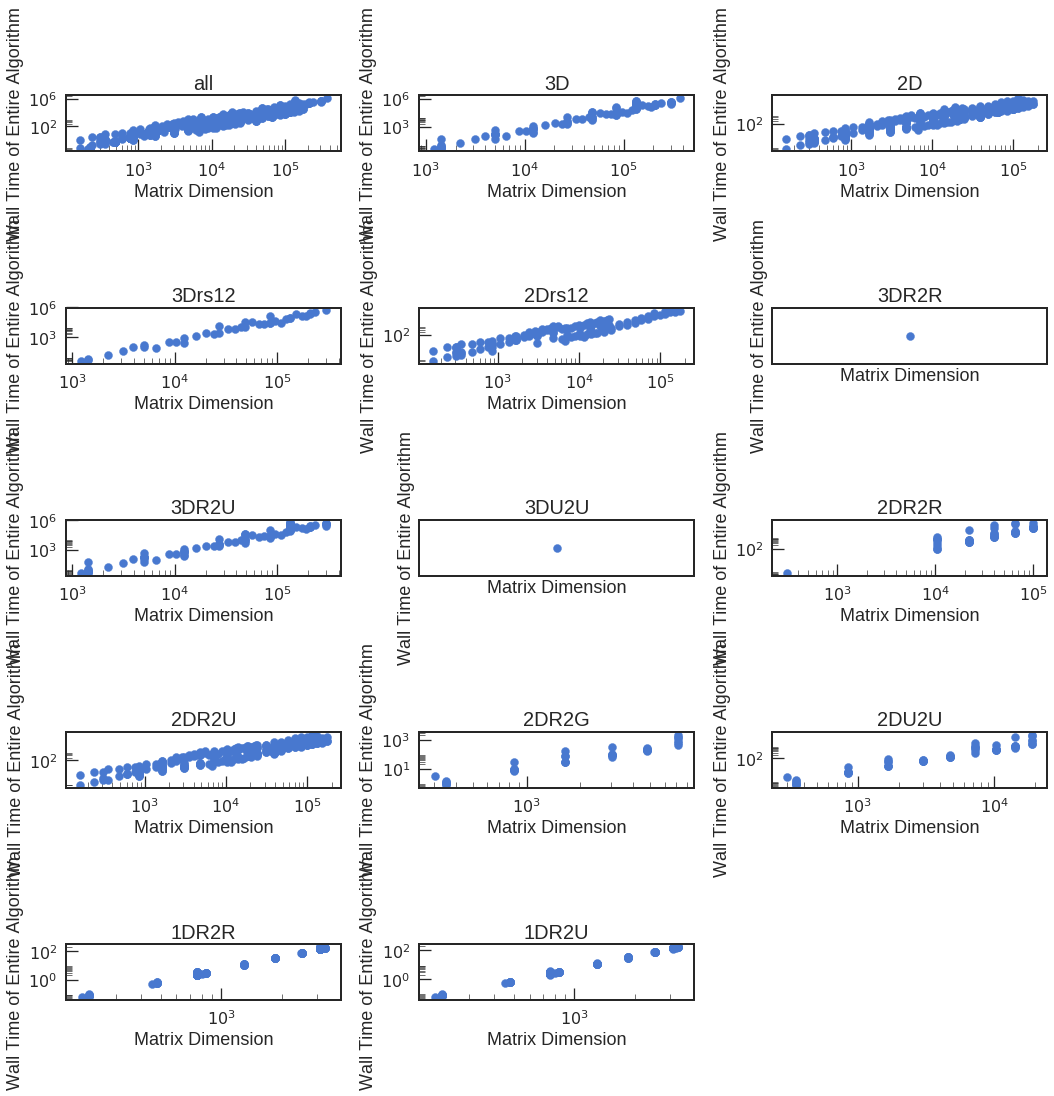

In [5]:
fig = plt.figure(figsize=(15, 15))
HFSA.subplotByDfDict(data, fig, HFSA.plot_runtime)
plt.tight_layout()
plt.show()

/home/evan/git/HF-Stability/analysis/pyfiles/HFSAnalyzer.py:428: RuntimeWarning: divide by zero encountered in log10
  c = np.polyfit(np.log10(Nmatfull)[-10:], np.log10(fulltimes)[-10:], 1)
/home/evan/git/HF-Stability/analysis/pyfiles/HFSAnalyzer.py:435: RuntimeWarning: divide by zero encountered in log10
  cdav = np.polyfit(np.log10(Nmat), np.log10(Davtimes), 1)
/home/evan/git/HF-Stability/analysis/pyfiles/HFSAnalyzer.py:435: RankWarning: Polyfit may be poorly conditioned
  cdav = np.polyfit(np.log10(Nmat), np.log10(Davtimes), 1)
/home/evan/git/HF-Stability/analysis/pyfiles/HFSAnalyzer.py:435: RankWarning: Polyfit may be poorly conditioned
  cdav = np.polyfit(np.log10(Nmat), np.log10(Davtimes), 1)
/home/evan/git/HF-Stability/analysis/pyfiles/HFSAnalyzer.py:428: RankWarning: Polyfit may be poorly conditioned
  c = np.polyfit(np.log10(Nmatfull)[-10:], np.log10(fulltimes)[-10:], 1)


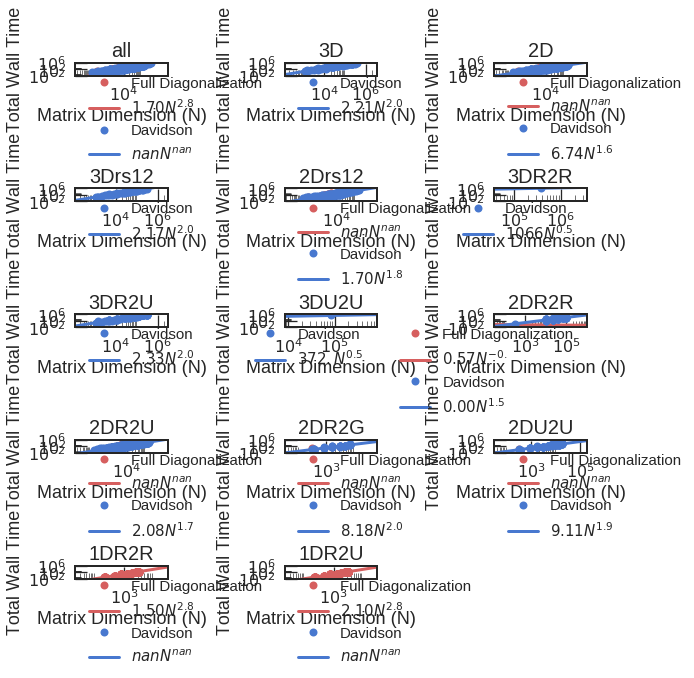

In [6]:
fig = plt.figure(figsize=(9, 9))
HFSA.subplotByDfDict(data, fig, HFSA.plot_diag_scaling)
plt.tight_layout()
plt.show()

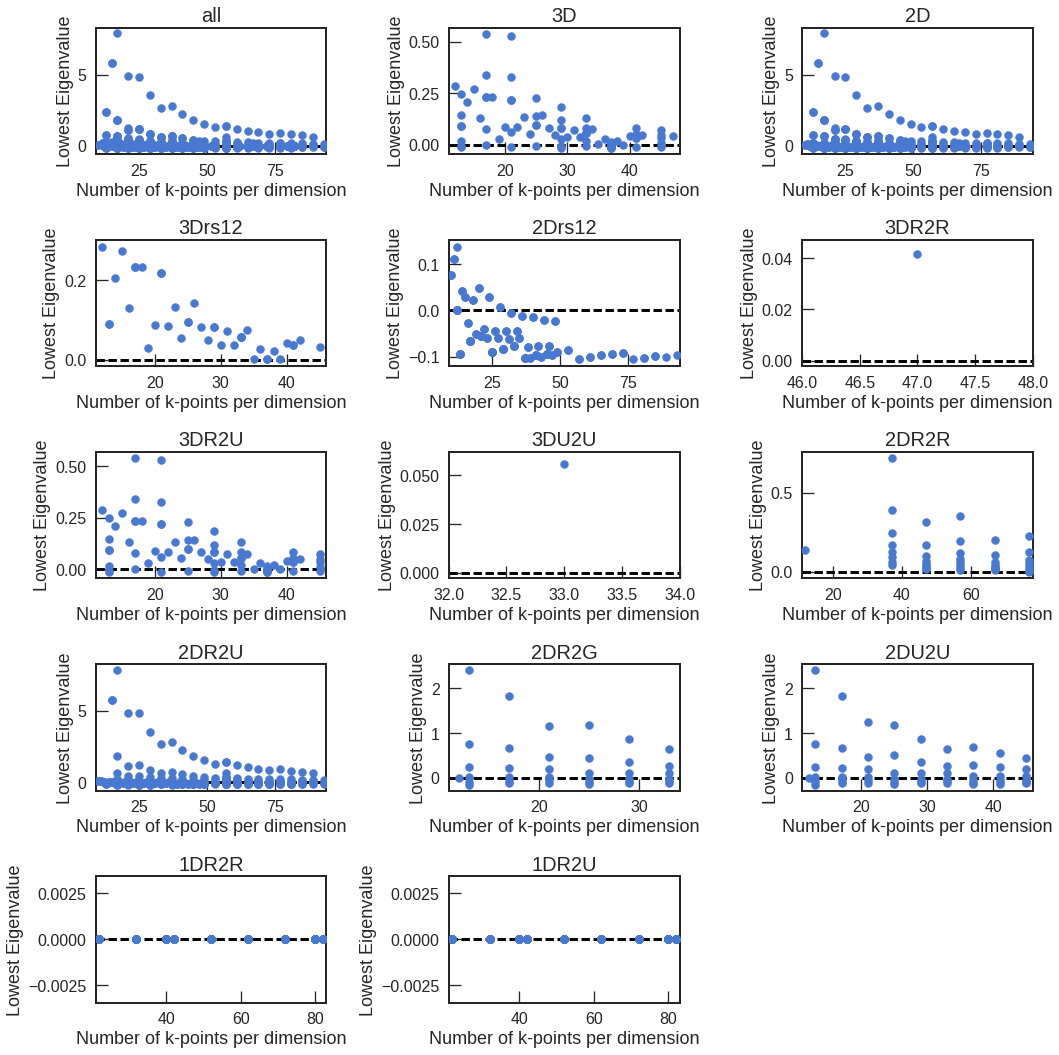

In [7]:
fig = plt.figure(figsize=(15, 15))
HFSA.subplotByDfDict(data, fig, HFSA.plot_dav_vs_full)
plt.tight_layout()
plt.show()

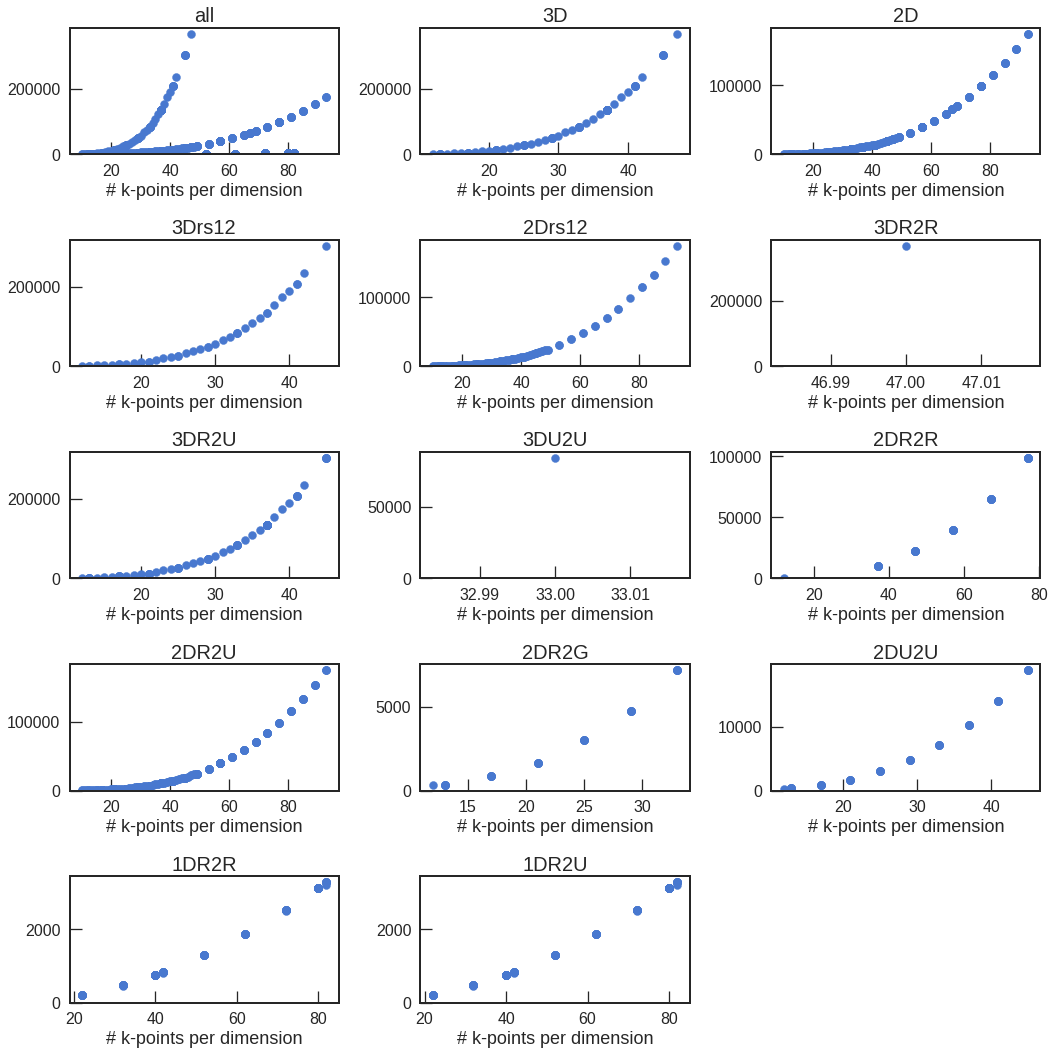

In [8]:
fig = plt.figure(figsize=(15,15))
HFSA.subplotByDfDict(data, fig, HFSA.plot_matrix_scaling)
plt.tight_layout()
plt.show()

/home/evan/git/HF-Stability/analysis/pyfiles/HFSAnalyzer.py:370: RuntimeWarning: divide by zero encountered in log10
  c = np.polyfit(np.log10(x_split), np.log10(mvtimes_split),  1)
/home/evan/local/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


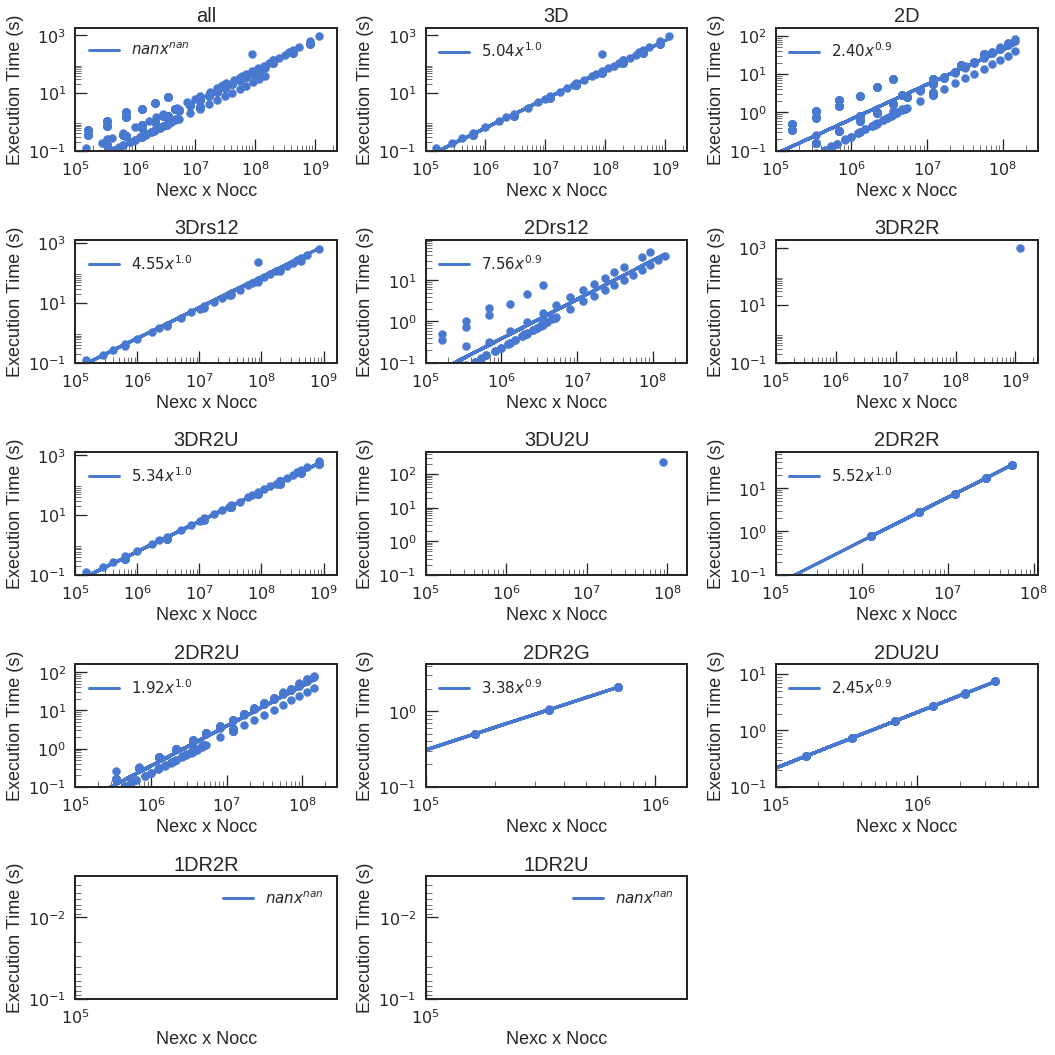

In [9]:
fig = plt.figure(figsize=(15, 15))
HFSA.subplotByDfDict(data, fig, HFSA.plot_mvproduct_scaling)
plt.tight_layout()
plt.show()

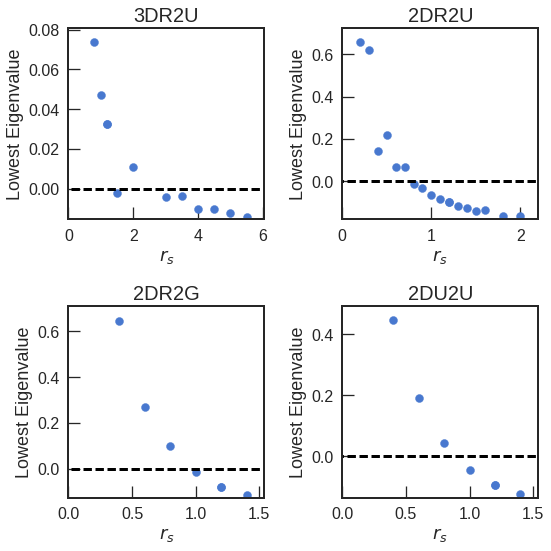

In [10]:
fig = plt.figure(figsize=(8, 8))

subview = dict_subview(data, ['2DR2U', '2DU2U', '2DR2G', '3DR2U'])
new_data = {key : HFSA.only_max(df, 'Nk', 'rs') for (key, df) in subview.items()}

HFSA.subplotByDfDict(new_data, fig, HFSA.plot_stability)
plt.tight_layout()
plt.show()

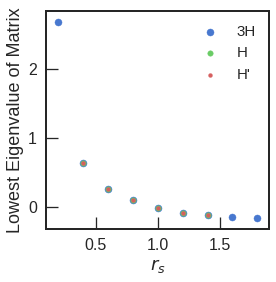

In [11]:
r2u = data['2DR2U'][data['2DR2U']['Nk'] == 33].sort_values(by='rs')
r2g = data['2DR2G'][data['2DR2G']['Nk'] == 33].sort_values(by='rs')
u2u = data['2DU2U'][data['2DU2U']['Nk'] == 33].sort_values(by='rs')

fig = plt.figure(figsize=(4, 4))
plt.scatter(r2u['rs'], r2u['dav_min_eval'], label="3H", s=50)
plt.scatter(r2g['rs'], r2g['dav_min_eval'], label='H', s=30)
plt.scatter(u2u['rs'], u2u['dav_min_eval'], label="H'", s=15)
plt.legend()
plt.ylabel('Lowest Eigenvalue of Matrix')
plt.xlabel('$r_s$')
plt.savefig('Matrix_Compare.pdf')
plt.show()

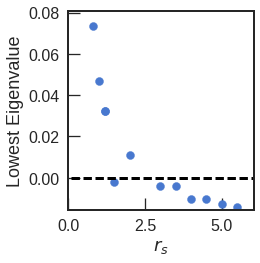

In [12]:
fig = plt.figure(figsize=(4, 4))
HFSA.plot_stability(HFSA.only_max(data['3DR2U'], 'Nk', 'rs'), fig.gca())
plt.tight_layout()
plt.show()

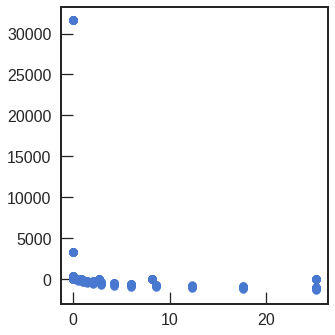

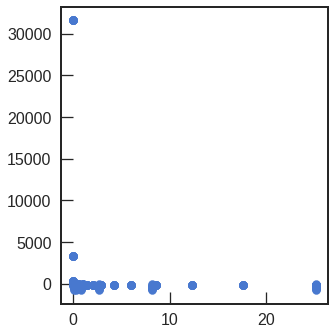

In [13]:
fig = plt.figure()
df1dmax = data['1DR2R'][data['1DR2R']['Nk'] == 80]
plt.scatter(df1dmax['rs'], df1dmax['full_diag_min'])
plt.tight_layout()
plt.show()

fig = plt.figure()
df1dmax = data['1DR2U'][data['1DR2U']['Nk'] == 80]
plt.scatter(df1dmax['rs'], df1dmax['full_diag_min'])
plt.tight_layout()
plt.show()

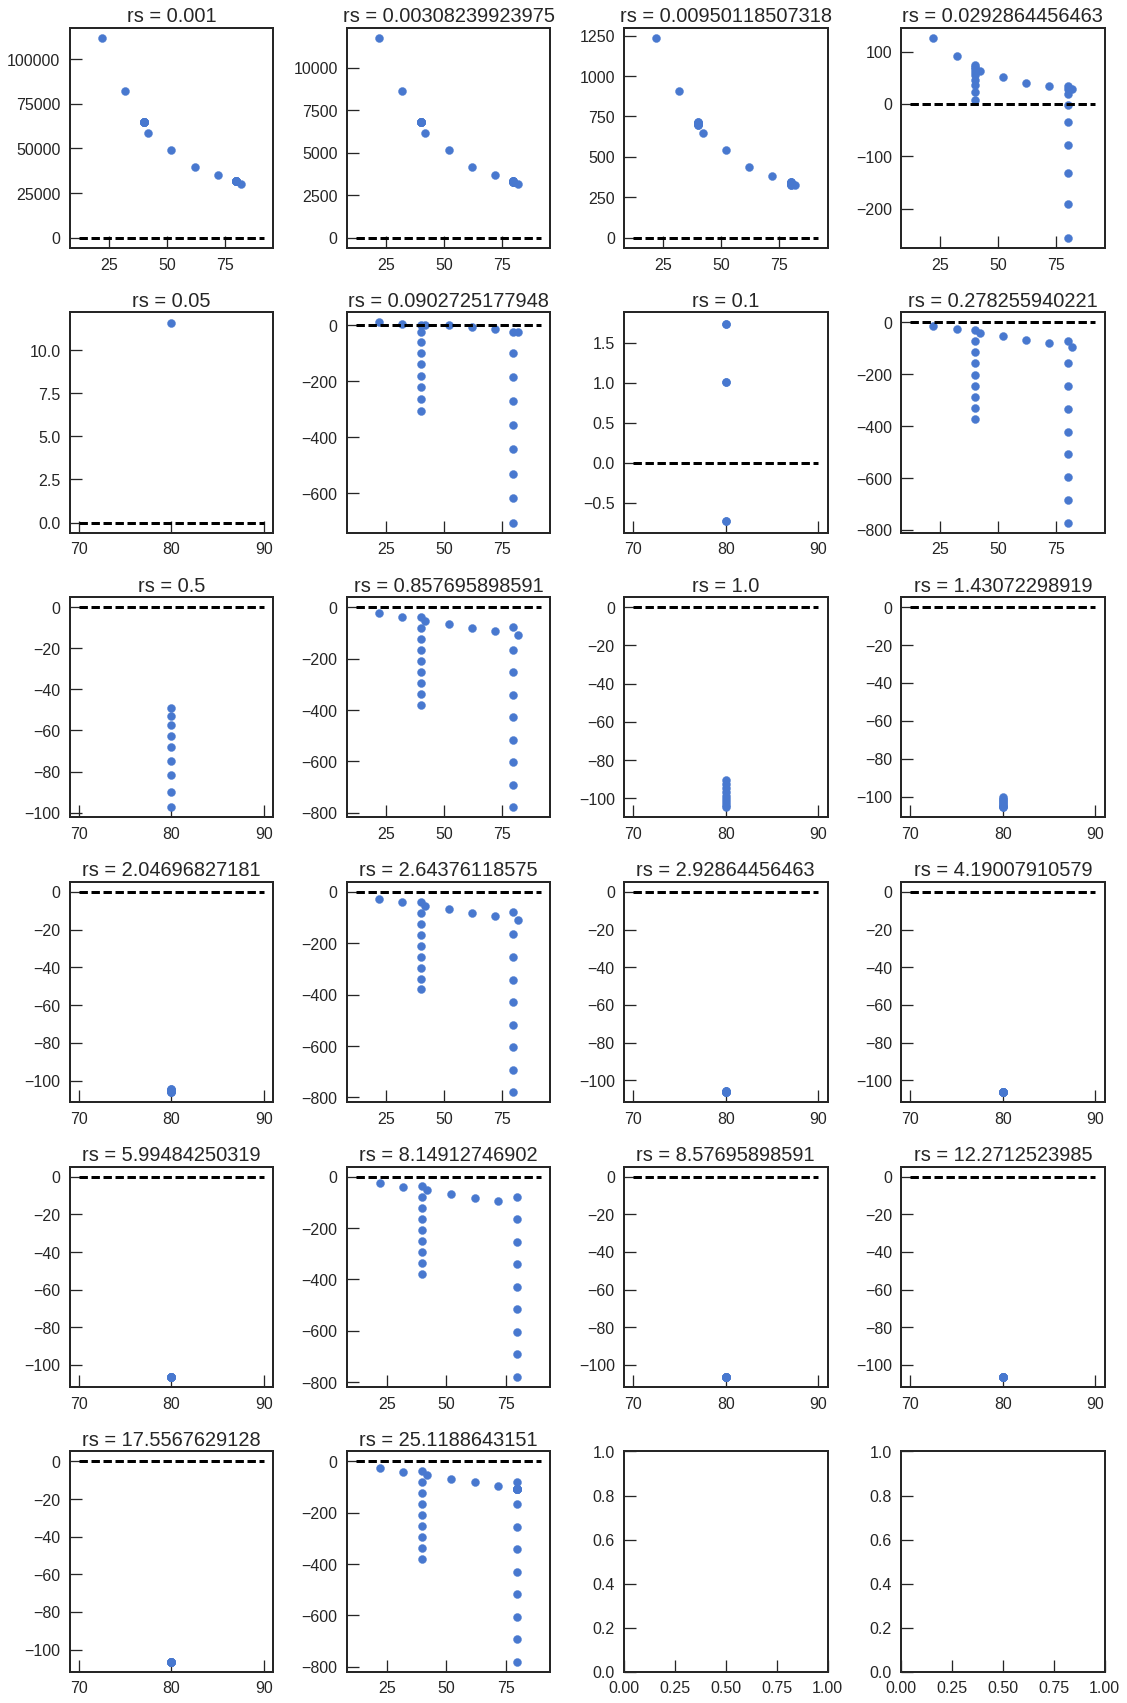

In [14]:
gp = data['1DR2U'].groupby('rs')

nrows, ncols = HFSA.get_square_tuple(N=len(gp))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
loc = [i[0] for i in np.ndenumerate(axes)]

count = 0
called = False

def eval_convergence(df, groupby=None):
    global count
    global called
    if called:
        ax = axes[loc[count][0], loc[count][1]]
        Nk = df.sort_values('Nk')['Nk']
        fullmin = df.sort_values('Nk')['full_diag_min']
        ax.scatter(Nk, fullmin)
        ax.set_title('rs = ' + str(df['rs'].iloc[0]))
        xmin = np.min(df['Nk']) - 10
        xmax = np.max(df['Nk']) + 10
        N = 100
        ax.plot(np.linspace(xmin, xmax, N), np.zeros(N), 'k--')
        count += 1
    else:
        called = True
        
gp.apply(eval_convergence, gp)
plt.tight_layout()
plt.show()

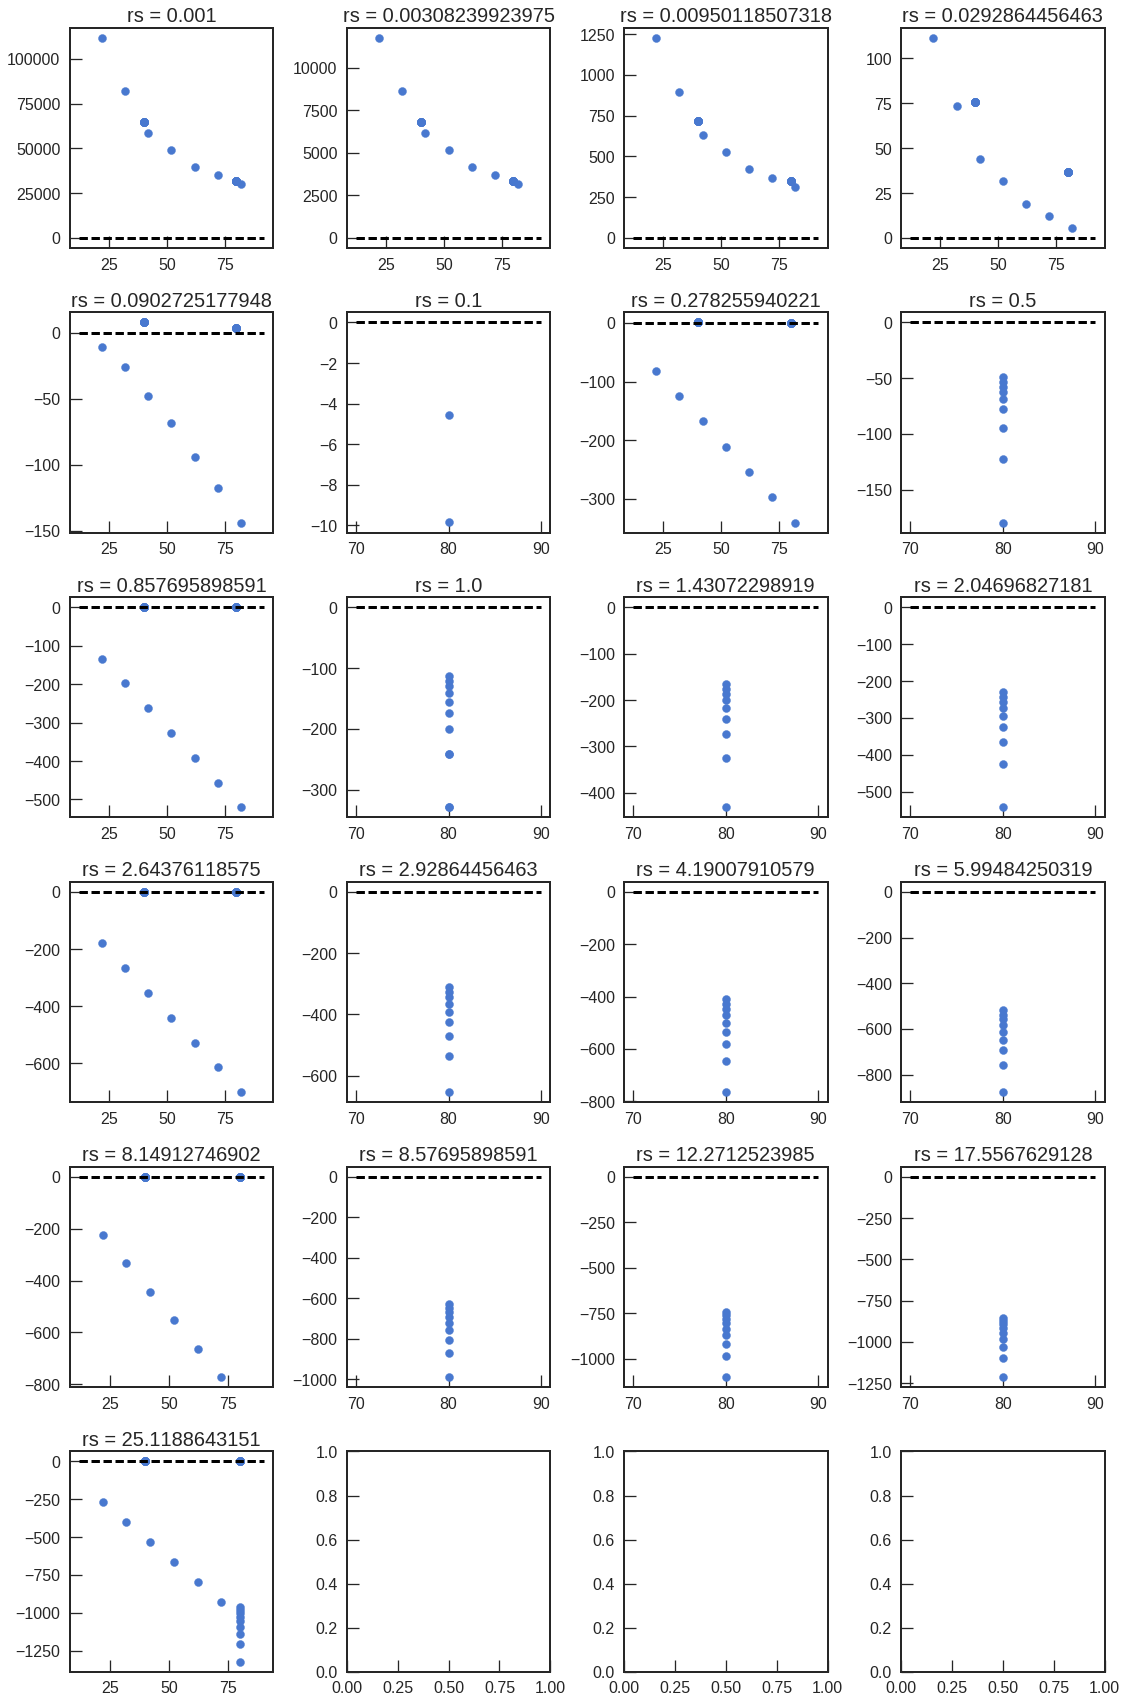

In [15]:
gp = data['1DR2R'].groupby('rs')

nrows, ncols = HFSA.get_square_tuple(N=len(gp))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
loc = [i[0] for i in np.ndenumerate(axes)]

count = 0
called = False

def eval_convergence(df, groupby=None):
    global count
    global called
    if called:
        ax = axes[loc[count][0], loc[count][1]]
        Nk = df.sort_values('Nk')['Nk']
        fullmin = df.sort_values('Nk')['full_diag_min']
        ax.scatter(Nk, fullmin)
        ax.set_title('rs = ' + str(df['rs'].iloc[0]))
        xmin = np.min(df['Nk']) - 10
        xmax = np.max(df['Nk']) + 10
        N = 100
        ax.plot(np.linspace(xmin, xmax, N), np.zeros(N), 'k--')
        count += 1
    else:
        called = True
        
gp.apply(eval_convergence, gp)
plt.tight_layout()
plt.show()

### Note: 17 May 2017
---
Checked whether the RHF-RHF being lower than RHF-UHF was due to changes in build. Both builds display the same
feature. I'm not sure if this is an error at this point. 

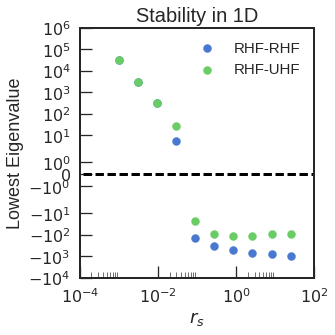

In [16]:
mask = data['1DR2U'].apply(lambda row: row['build_date'] == 'Apr  8 2017-16:05:45', axis=1)
mask2 = np.asarray([i for i in mask])
dat_build1_r2u = data['1DR2U'][mask2]

mask = data['1DR2R'].apply(lambda row: row['build_date'] == 'Apr  8 2017-16:05:45', axis=1)
mask2 = np.asarray([i for i in mask])
dat_build1_r2r = data['1DR2R'][mask2]


dfr2rmax = HFSA.only_max(dat_build1_r2r, maximize='Nk', unique='rs')
dfr2umax = HFSA.only_max(dat_build1_r2u, maximize='Nk', unique='rs')

fig = plt.figure()
plt.scatter(dfr2rmax['rs'], dfr2rmax['full_diag_min'], label='RHF-RHF')
plt.scatter(dfr2umax['rs'], dfr2umax['full_diag_min'], label='RHF-UHF')
plt.plot(np.linspace(0, 100, 50), np.zeros(50), 'k--')
plt.xscale('log')
plt.yscale('symlog')
plt.xlim(1e-4, 1e2)
plt.ylim(-1e4, 1e6)
plt.xlabel('$r_s$')
plt.ylabel('Lowest Eigenvalue')
plt.title('Stability in 1D')
plt.legend()
plt.tight_layout()
plt.savefig('1dstab.pdf')
plt.show()

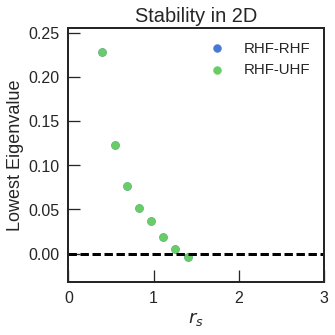

In [17]:
dfr2rmax = HFSA.only_max(data['2DR2R'], maximize='Nk', unique='rs')
dfr2umax = HFSA.only_max(data['2DR2U'], maximize='Nk', unique='rs')

dfr2rmax = dfr2rmax[dfr2rmax.Nk == 77]
dfr2umax = dfr2rmax[dfr2rmax.Nk >= 57]
#print(dfr2r77.Nk)

fig = plt.figure()
plt.scatter(dfr2rmax['rs'], dfr2rmax['dav_min_eval'], label='RHF-RHF')
plt.scatter(dfr2umax['rs'], dfr2umax['dav_min_eval'], label='RHF-UHF')
plt.plot(np.linspace(0, 100, 50), np.zeros(50), 'k--')
#plt.xscale('log')
plt.xlim(1e-4, 3)
#plt.ylim(-2000, 35000)
plt.xlabel('$r_s$')
plt.ylabel('Lowest Eigenvalue')
plt.title('Stability in 2D')
plt.legend()
plt.tight_layout()
plt.savefig('2dstab.pdf')
plt.show()

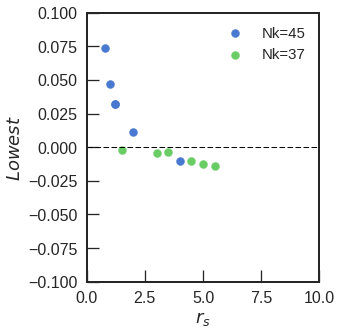

In [18]:
#dfr2rmax = HFSA.only_max(data['3DR2R'], maximize='Nk', unique='rs')
dfr2umax = HFSA.only_max(data['3DR2U'], maximize='Nk', unique='rs')
dfr2umax45 = dfr2umax[dfr2umax['Nk'] == 45]
dfr2umax37 = dfr2umax[dfr2umax['Nk'] == 37]
fig = plt.figure()
#plt.scatter(dfr2rmax['rs'], dfr2rmax['full_diag_min'], label='RHF-RHF')
plt.scatter(dfr2umax45['rs'], dfr2umax45['dav_min_eval'], label='Nk=45')
plt.scatter(dfr2umax37['rs'], dfr2umax37['dav_min_eval'], label='Nk=37')
plt.plot(np.linspace(0, 100, 50), np.zeros(50), 'k--', lw=1)
#plt.xscale('log')
plt.xlim(1e-4, 10)
plt.ylim(-0.1, 0.1)
ax = plt.gca()
#ax.set_yticks([-0.1, -0.1])

plt.xlabel('$r_s$')
#plt.yscale('symlog')
plt.ylabel('$Lowest~Eigenvalue$')
#plt.title('$Stability~in~3D$')
plt.legend()
plt.tight_layout()
plt.savefig('3dstab.pdf')
plt.show()

## Testing RHF-GHF, RHF-UHF equivalence, various matrix factorizations
---

Starting from the RHF solution, I've shown mathematically that the various instabilities factorize into only two types, RHF-RHF and RHF-UHF. The Other instabilities can all be expressed as combinations of these. This is the numerical verification of the mathematics. 

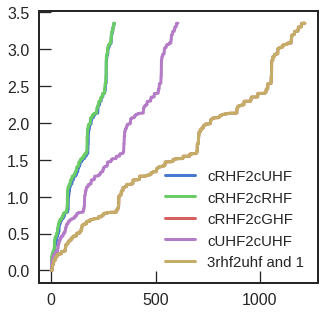

All within 1e-10? :  True


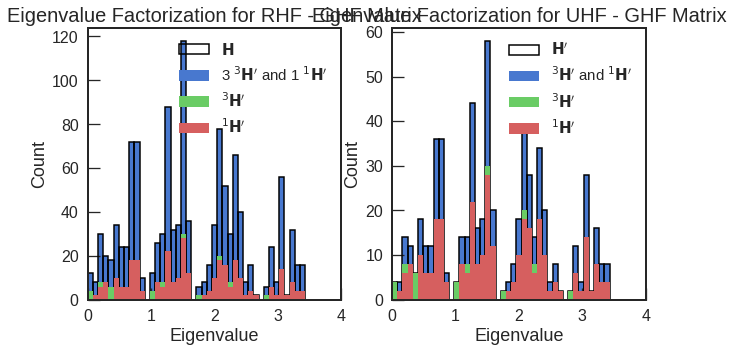

In [19]:
temp = data['2D'][data['2D']['Nk'] == 12].dropna(subset=['exact_evals'])
evaldic = {temp['mycase'].iloc[i] : temp['exact_evals'].iloc[i] for i in range(len(temp))}

fig = plt.figure()
for key, val in evaldic.items():
    plt.plot(range(len(val)), val, label=key)
    

sort = np.sort(np.concatenate([ evaldic['cRHF2cRHF']
                               ,evaldic['cRHF2cUHF']
                               ,evaldic['cRHF2cUHF']
                               ,evaldic['cRHF2cUHF'] ]))
plt.plot(range(len(sort)), sort, label='3rhf2uhf and 1')
plt.legend()
plt.show()

print("All within 1e-10? : ", np.all(np.abs(sort - evaldic['cRHF2cGHF']) < 1e-10))

# the histogram of the data
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
xmin, xmax = (0, 4)
binset = np.linspace(xmin, xmax, 50)
ax1.hist(evaldic['cRHF2cGHF'], bins=binset, histtype='bar', stacked=True, label="$\mathbf{H}$", fill=False, color='r'
        , linewidth=1.5, zorder=1)
ax1.hist(sort, bins=binset, histtype='bar', stacked=True, label="3 ${}^3\mathbf{H}'$ and 1 ${}^1\mathbf{H}'$", zorder=0)

ax1.hist(evaldic['cRHF2cUHF'], bins=binset, histtype='bar', stacked=True, label="${}^3\mathbf{H}'$")
ax1.hist(evaldic['cRHF2cRHF'], bins=binset, histtype='bar', stacked=True, label="${}^1\mathbf{H}'$")
ax1.set_title('Eigenvalue Factorization for RHF - GHF Matrix')
ax1.legend()
ax1.set_xlabel('Eigenvalue')
ax1.set_ylabel('Count')
ax1.set_xlim(xmin, xmax)

xmin, xmax = (0, 4)
binset = np.linspace(xmin, xmax, 50)
ax2.hist(evaldic['cUHF2cUHF'], bins=binset, histtype='bar', stacked=True, 
         label="$\mathbf{H}'$", fill=False, linewidth=1.5, zorder=1)
ax2.hist(np.concatenate([evaldic['cRHF2cUHF'], evaldic['cRHF2cRHF']]), 
         bins=binset, histtype='bar', stacked=True, label="${}^3\mathbf{H}'$ and ${}^1\mathbf{H}'$", 
         color=sns.color_palette()[0], zorder=0)

ax2.hist(evaldic['cRHF2cUHF'], bins=binset, histtype='bar', stacked=True, label="${}^3\mathbf{H}'$", color=sns.color_palette()[1])
ax2.hist(evaldic['cRHF2cRHF'], bins=binset, histtype='bar', stacked=True, label="${}^1\mathbf{H}'$", color=sns.color_palette()[2])
ax2.set_xlim(xmin, xmax)
ax2.set_title('Eigenvalue Factorization for UHF - GHF Matrix')
ax2.legend()
ax2.set_xlabel('Eigenvalue')
ax2.set_ylabel('Count')
#plt.savefig('matrix_factor_histograms.pdf')
plt.show()

# Analysis for 1D Case: Delta Function and Coulomb Potentials
---

The delta function potential was used by Overhauser in his paper and therefore is interesting to investigate computationally. The Coulomb potential is treated in a 'pseudo-1D' fashion, in which the space considered is a cylinder of width *a*, where the value of *a* is chosen to 'freeze' the motion of the electrons except for motion along the axis.  

In [20]:
data['1D'] = df[df['NDIM'] == 1]
data['1D_delta'] = df[df['use_delta_1D']]
data['1D_delta_R2R'] = data['1D_delta'][data['1D_delta'].mycase.str.contains('cRHF2cRHF')]
data['1D_delta_R2U'] = data['1D_delta'][data['1D_delta'].mycase.str.contains('cRHF2cUHF')]
data['1D_coul']  = df[np.logical_not(df['use_delta_1D'])]
data['1D_coul_R2R'] = data['1D_coul'][data['1D_coul'].mycase.str.contains('cRHF2cRHF')]
data['1D_coul_R2U'] = data['1D_coul'][data['1D_coul'].mycase.str.contains('cRHF2cUHF')]

### For Delta Function Potential, RHF-UHF and RHF-RHF are equivalent. 
---

The singlet instability matrices are:

$A_{st} = (E_a - E_i)\delta_{st} + 2 (aj|ib) - (aj|bi)$

$B_{st} = -(ab|ji) + 2 (ab|ij)$

While the triplet instability matrices are:

$A_{st} = (E_a - E_i)\delta_{st} - (aj|bi)$

$B_{st} = -(ab|ji)$

Due to the symmetry of the two electron integrals under the delta function potential,
$(pq|rs) = (qp|rs) = (pq|sr) = (qp|sr)$

these differ only by the sign of all off diagonals, and have the same eigenspectra.

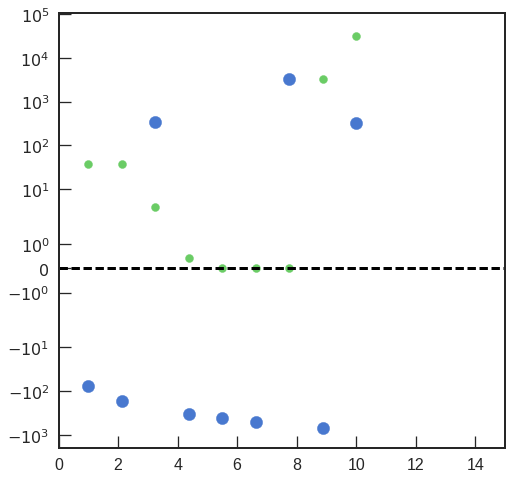

In [21]:
maxdata_delta_R2U = data['1D_delta_R2U'].dropna(subset=['twoE_parameter_1dCase'])
maxdata_delta_R2U = HFSA.only_max(df=maxdata_delta_R2U, maximize='Nk', unique='twoE_parameter_1dCase')

maxdata_delta_R2R = data['1D_delta_R2R'].dropna(subset=['twoE_parameter_1dCase'])
maxdata_delta_R2R = HFSA.only_max(df=maxdata_delta_R2R, maximize='Nk', unique='twoE_parameter_1dCase')



fig = plt.figure(figsize=(8,8))
plt.plot(np.linspace(1e-10, 1e10, 50), np.zeros(50), 'k--')
plt.xlim(0, 15)
plt.yscale('symlog')
plt.scatter(maxdata_delta_R2U['twoE_parameter_1dCase'], maxdata_delta_R2U['full_diag_min'], s = 150)
plt.scatter(maxdata_delta_R2R['twoE_parameter_1dCase'], maxdata_delta_R2R['full_diag_min'])

## Testing Pandas merge (analagous to SQL Join)
---
This is very promising. Can join on multiple rows to compare two cases where all other params
are the same!

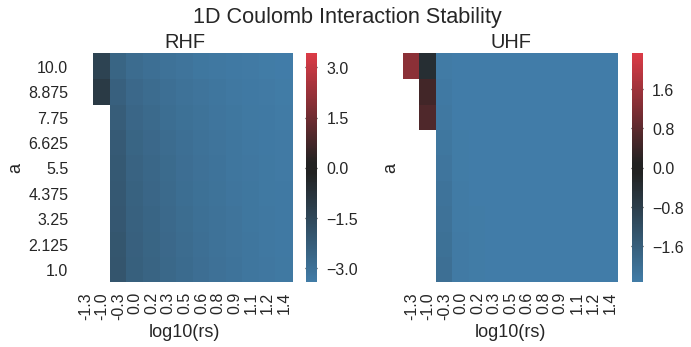

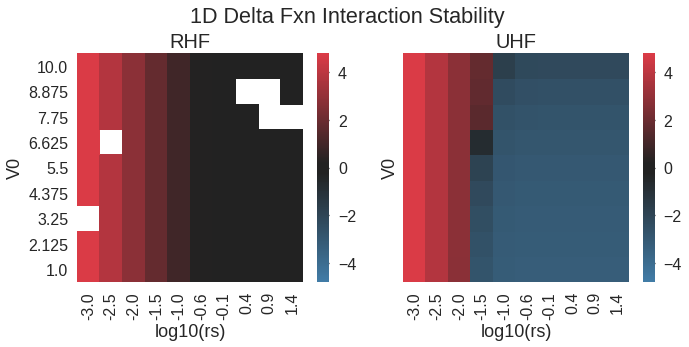

In [22]:
def symlog(x):
    return np.sign(x) * np.log10(1 + np.abs(2*x))  

def sidebyside_heatmap(df1, df2):
    """Draws stability heatmaps for the rs and parameter
    
    The data colored by the symlog(x) function, but the colormap labels
    are the actual numbers. 
    
    """
    cols = ['NDIM', 'Nk', 'rs', 'mycase', 'twoE_parameter_1dCase', 'full_diag_min']
    merge_cols = ['NDIM', 'Nk', 'rs', 'twoE_parameter_1dCase']
    test = pd.merge(df1[cols], df2[cols], how='outer', on=merge_cols)
    test = test.set_index('rs').sort_index()

    newcols = { 'full_diag_min_x'      : 'RHF'
               ,'full_diag_min_y'      : 'UHF'
               ,'twoE_parameter_1dCase': 'a' 
              }
    test = test.rename(columns=newcols)

    test = test.set_index(['a'], append=True)

    fig, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)

    keys = [newcols[i] for i in ('full_diag_min_x','full_diag_min_y')]

    
    for idx, plot_axis in enumerate(axes):
        # Plot scaled data
        unstacked = test[keys[idx]].drop_duplicates().unstack(level=0)
        C = 1.0 / np.log(10)
        unstacked_scaled = symlog(unstacked)
        mask = unstacked_scaled.isnull()
        cmap = sns.diverging_palette(h_neg=240, h_pos=10, as_cmap=True, center='dark')

        sns.heatmap(unstacked_scaled, center=0.0, ax=plot_axis, mask=mask, cmap=cmap)
        
        rslist = [level for level in test.index.levels if level.name == 'rs'][0]
        rslist = np.round(np.log10(rslist), 1)
        plot_axis.set_xticklabels(rslist)
        plot_axis.set_title(keys[idx])
        a = np.asarray([level for level in test.index.levels if level.name == 'a'][0])
        
        ylabels = plot_axis.set_yticklabels(a)
        plot_axis.set_xlabel('log10(rs)')
        plot_axis.xaxis.set_ticks_position('none')
        plot_axis.yaxis.set_ticks_position('none') 
        
        # plot_axis.text(17.5, 6, 'Scaled Min EigVal', fontsize=12, rotation=-90)
        

        
    return fig, axes
    
maxdata_coul_R2R_80Nk = data['1D_coul_R2R'][data['1D_coul_R2R']['Nk'] == 80]
maxdata_coul_R2U_80Nk = data['1D_coul_R2U'][data['1D_coul_R2U']['Nk'] == 80]
fig, axes = sidebyside_heatmap(maxdata_coul_R2R_80Nk, maxdata_coul_R2U_80Nk)
fig.suptitle('1D Coulomb Interaction Stability')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

maxdata_delta_R2R = data['1D_delta_R2R'].dropna(subset=['twoE_parameter_1dCase'])
maxdata_delta_R2U = data['1D_delta_R2U'].dropna(subset=['twoE_parameter_1dCase'])
maxdata_delta_R2R_80Nk = maxdata_delta_R2R[maxdata_delta_R2R['Nk'] == 80]
maxdata_delta_R2U_80Nk = maxdata_delta_R2U[maxdata_delta_R2U['Nk'] == 80]
fig, axes = sidebyside_heatmap(maxdata_delta_R2R_80Nk, maxdata_delta_R2U_80Nk)
fig.suptitle('1D Delta Fxn Interaction Stability')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
for ax in axes:
    ax.set_ylabel('V0')
plt.show()

## Above this Was mostly experimental findings used for working. Below This are images specifically tailored to the paper.
---

In [23]:
a = np.logspace(-3, 5, 10)
b = -np.logspace(-3, 5, 10)
c = np.hstack((a,b))
sgn = np.sign(c)
np.log10(np.abs(c))

array([-3.        , -2.11111111, -1.22222222, -0.33333333,  0.55555556,
        1.44444444,  2.33333333,  3.22222222,  4.11111111,  5.        ,
       -3.        , -2.11111111, -1.22222222, -0.33333333,  0.55555556,
        1.44444444,  2.33333333,  3.22222222,  4.11111111,  5.        ])

In [24]:
a = np.logspace(-5, 5, 10)
b = -np.logspace(-5, 5, 10)
c = np.hstack((b, a))
dict(zip(symlog(c), c))

{-5.3010321671309617: -100000.0,
 -4.189946929291982: -7742.6368268112774,
 -3.0791698458987082: -599.48425031894214,
 -1.9723499396194895: -46.415888336127821,
 -0.91315806686220491: -3.5938136638046259,
 -0.19215243988551928: -0.27825594022071259,
 -0.01832123804350605: -0.021544346900318846,
 -0.0014464821788396462: -0.0016681005372000592,
 -0.00011216809208139851: -0.00012915496650148841,
 -8.6858027802872283e-06: -1.0000000000000001e-05,
 8.6858027802872283e-06: 1.0000000000000001e-05,
 0.00011216809208139851: 0.00012915496650148841,
 0.0014464821788396462: 0.0016681005372000592,
 0.01832123804350605: 0.021544346900318846,
 0.19215243988551928: 0.27825594022071259,
 0.91315806686220491: 3.5938136638046259,
 1.9723499396194895: 46.415888336127821,
 3.0791698458987082: 599.48425031894214,
 4.189946929291982: 7742.6368268112774,
 5.3010321671309617: 100000.0}